# Libraries

In [1]:
# These have to be installed through running "pip install -r requirements.txt"

import re # for regular expressions
import numpy as np # for numerical computation
import pandas as pd # for data manipulation
import matplotlib.pyplot as plt # for plotting
import sklearn  # machine learning library
import nltk # natural language toolkit
import re # for regular expressions

from nltk.corpus import stopwords # to remove stopwords
from nltk.tokenize import word_tokenize # to tokenize
from nltk.stem import WordNetLemmatizer # to lemmatize
from nltk.sentiment.vader import SentimentIntensityAnalyzer # to analyze sentiment

from wordcloud import WordCloud # to visualize text
from PIL import Image # to load images

from gensim.test.utils import common_texts  # some example texts

from sklearn.feature_extraction.text import TfidfVectorizer # to convert text to numbers 
from sklearn.naive_bayes import MultinomialNB # to build a model
from sklearn.linear_model import LogisticRegression # to build a model
from sklearn.svm import LinearSVC # to build a model
from sklearn.model_selection import train_test_split # to split the data
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix, mean_squared_error  # to evaluate the model
from sklearn.metrics import classification_report # to evaluate the model

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from keras.utils import pad_sequences
from tensorflow.keras.metrics import Precision, Recall, AUC
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import MinMaxScaler 

# Intro:
 The objective of this project is to conduct sentiment analysis on a dataset of hotel reviews in order to predict a corresponding review score based on the textual content of each review. By leveraging natural language processing techniques, we aim to analyze the sentiments expressed in the reviews and establish a predictive model that can automatically generate a review score.

In this first section we want to visualize the data to get a better understanding of the dataset. The dataset includes 17 columns, where each row is a hotel review. The columns include a person’s experience with a certain hotel, where they are from and the location of the hotel. 
The data we want to focus on later in this analysis is the written review and the review score, however we include this section in order for you to get a better overview of the dataset.


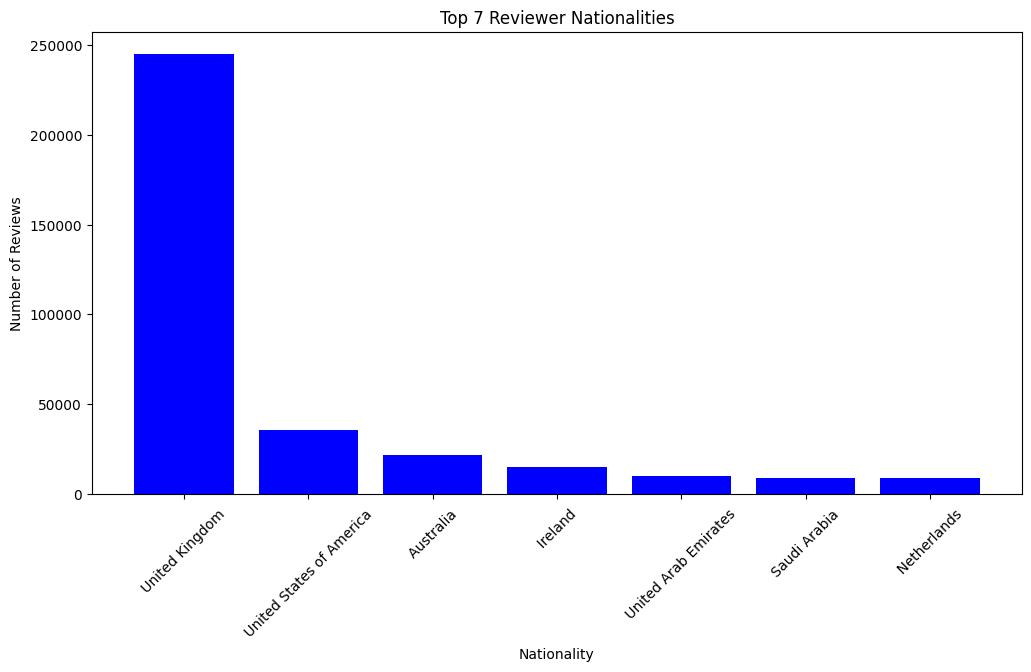

In [2]:
# Distrobution of nationality (top 7 nationalities)
df = pd.read_csv('Hotel_Reviews.csv')

top_nationalities = df['Reviewer_Nationality']. value_counts().head(7)

plt.figure(figsize=(12, 6))
plt.bar(top_nationalities.index, top_nationalities.values, color='blue')
plt.xticks(rotation=45)
plt.title("Top 7 Reviewer Nationalities")
plt.xlabel("Nationality")
plt.ylabel("Number of Reviews")
plt.show()

The majority of the reviewers are from English speaking countries. The dataset only includes English written reviews.

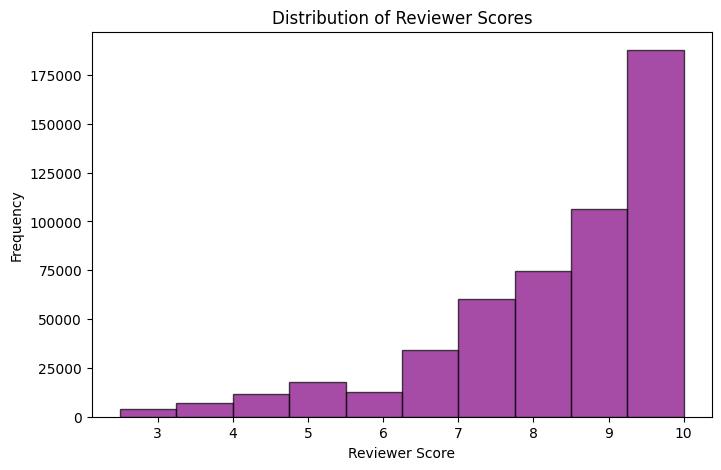

In [3]:
plt.figure(figsize=(8, 5))

# Review Score Distribution
plt.hist(df['Reviewer_Score'], bins=10, color="purple", edgecolor="black", alpha=0.7)
plt.title("Distribution of Reviewer Scores")
plt.xlabel("Reviewer Score")
plt.ylabel("Frequency")
plt.show()

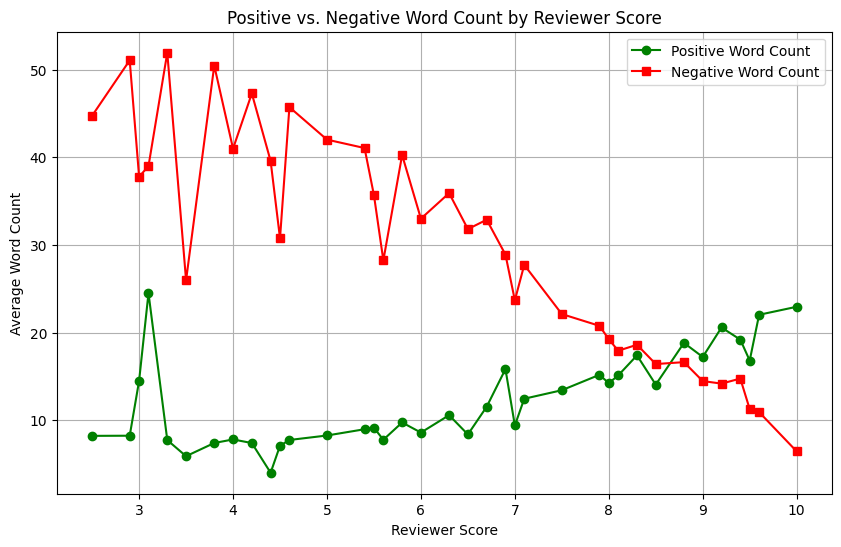

In [4]:
review_score_grouped = df.groupby("Reviewer_Score")[
    ["Review_Total_Positive_Word_Counts", "Review_Total_Negative_Word_Counts"]
].mean()

# Create figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Plot both lines
ax.plot(review_score_grouped.index, review_score_grouped["Review_Total_Positive_Word_Counts"],
        marker="o", linestyle="-", color="green", label="Positive Word Count")

ax.plot(review_score_grouped.index, review_score_grouped["Review_Total_Negative_Word_Counts"],
        marker="s", linestyle="-", color="red", label="Negative Word Count")

# Labels and title
ax.set_xlabel("Reviewer Score")
ax.set_ylabel("Average Word Count")
ax.set_title("Positive vs. Negative Word Count by Reviewer Score")
ax.legend()
ax.grid(True)

# Show plot
plt.show()

This graph shows the average word could for each review score. This graph is important because it tells us how many positive/negative words are in a review based on the reviewer score. The two graphs intersect at around 8.5, which is the number we use to separate negative reviews from positive reviews. 

We randomly sample x reviews from each group to create a balanced dataset. Random state is set to 42 which ensures reproducibility of the random sampling. We then concatenate the two samples and shuffle the rows, marking them as positive for reviews with scores larger than 8.5 and as negative for reviews with scores smaller then 8.5

In [5]:
# Storing the csv file as a pandas dataframe and sample 50/50 of the positive and negative scores
# Separate reviews
positive_reviews = df[df['Reviewer_Score'] > 8.5]
negative_reviews = df[df['Reviewer_Score'] < 8.5]

# Find the smallest class size (negatives)
min_count = min(len(positive_reviews), len(negative_reviews))
print(f"Using {min_count} samples from each class for balance")

# Sample equal number from both
positive_sample = positive_reviews.sample(n=min_count, random_state=42)
negative_sample = negative_reviews.sample(n=min_count, random_state=42)

# Combine and shuffle
balanced_df = pd.concat([positive_sample, negative_sample])
df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Check the new balance
print(df['Reviewer_Score'].apply(lambda x: 'positive' if x > 8.5 else 'negative').value_counts())

Using 221764 samples from each class for balance
Reviewer_Score
positive    221764
negative    221764
Name: count, dtype: int64


We replace the ‘no positive’ and ‘no negative’ reviews with an empty space. This helps reduce noise before we begin the sentiment analysis. 

In [6]:
def replace(cell): 
    if cell == "No Positive" or cell == "No Negative":
        return ""
    return cell

df['Negative_Review'] = df['Negative_Review'].apply(replace)
df['Positive_Review'] = df["Positive_Review"].apply(replace)

We then combine the positive and negative reviews to make them into a singular row called ‘review’

In [7]:
def combine_names(row):
    return f"{row['Positive_Review']} {row['Negative_Review']}"


df["Review"] = df.apply(combine_names, axis="columns")

The columns we want to focus on now is the reviewer_score and Review columns. The other columns are irrelevant because we want to predict the reviewer_score based on the review

In [8]:
df = df.drop(["Hotel_Address", "Additional_Number_of_Scoring", "Review_Date", "Average_Score", "Reviewer_Nationality", "Review_Total_Negative_Word_Counts", "Review_Total_Positive_Word_Counts", "Total_Number_of_Reviews_Reviewer_Has_Given", "Tags", "days_since_review", "lat", "lng", "Hotel_Name", "Total_Number_of_Reviews", "Negative_Review", "Positive_Review"], axis = "columns")
df

,Reviewer_Score,Review
0,9.2,Amazing location and easy to get to anywhere ...
1,9.2,Very nice helpful young and dynamic staff and...
2,9.6,I like the design of building Nice high stand...
3,9.6,The old but elegant structure architecture of...
4,8.8,Really good location in terms of tubes statio...
...,...,...
443523,8.3,the room was a good size it was very clean th...
443524,7.5,Sink in bathroom too small couldn t wash tee...
443525,10.0,Amazing as always we always get a suite never...
443526,10.0,The hotel and staff were wonderful and made o...


Here, we preprocess the text by cleaning it up to further reduce noise. This will make the text better fitted for machine learning. The word lemmatizer converts words into their base form, making the analysis more efficient. We also tokenize the words to turn the sentiments into a structured format that a model can interpret. 

In [9]:
# Initialize the lemmatizer
lemmatizer = WordNetLemmatizer()

# Define the preprocessing function
def preprocess_text(text):
    # 1. Lowercase
    text = text.lower()
    
    # 2. Remove special characters and numbers (keep only letters and spaces)
    text = re.sub(r'[^a-z\s]', '', text)
    
    # 3. Tokenize
    tokens = word_tokenize(text)
    
    # 4. Remove stopwords
    filtered_tokens = [token for token in tokens if token not in stopwords.words('english')]
    
    # 5. Lemmatize
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]
    
    # 6. Join back into a string
    processed_text = ' '.join(lemmatized_tokens)
    
    return processed_text

# Apply to your DataFrame
df['Review'] = df['Review'].apply(preprocess_text)

KeyboardInterrupt: 

In [ ]:
# Add a column for y, which gives the review either positive or negative
df['posneg'] = df['Reviewer_Score'].apply(lambda x: 0 if x < 8.5 else 1)

In [ ]:
# Preprocess for LSTM

# Tokenizer setup
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(df['Review'])

# Convert reviews to sequences
sequences = tokenizer.texts_to_sequences(df['Review'])

# Pad sequences (adjust maxlen as needed)
maxlen = 50
padded = pad_sequences(sequences, padding='post', truncating='post', maxlen=maxlen)

We now wish to create a dedicated train-test split for the LSTM model we are using. This separate split is important because of how LSTMs operate: unlike models that rely on TF-IDF representations where word order is ignored, LSTMs process sequences of words in their original order. This allows the model to capture contextual information, such as in the difference between "good" and "not good", where the presence of "not" before "good" completely changes the sentiment. To preserve this sequential information and ensure that the model learns effectively, we construct a specific split suited to the needs of the LSTM.

In [ ]:
X_LSTM = padded
y_LSTM = df['posneg']

X_train_LSTM, X_test_LSTM, y_train_LSTM, y_test_LSTM = train_test_split(
    padded, df['posneg'], test_size=0.25, random_state=42
)

Next, we prepare the training data by classifying the reviews into positive and negative categories. Positive reviews are labelled with a 1, while negative reviews are labelled with a 0. After assigning these labels, we define separate variables to hold the positive and negative training datasets, each containing the corresponding review text.

In [ ]:
# Calculate Positive and Negative Reviews
train_pos = df[ df['posneg'] == 1]
train_pos = train_pos['Review']
train_neg = df[ df['posneg'] == 0]
train_neg = train_neg['Review']

Using the WordCloud library we define a function that generates word clouds from the pre-processed text, allowing us to visually explore the most frequent words from the reviews. To enhance the quality of the word cloud, we also implemented a function to remove some common ‘neutral’ words from the reviews to reduce noise and to ensure that the most relevant words are highlighted.

In [ ]:
# Generate WordCloud function for negative and positive reviews
# source: https://medium.com/@amalia.wulandiari/sentiment-analysis-hotel-review-python-nltk-846738de727f

def wordCloud_generator(data, color, color_map):

    
    wordcloud = WordCloud(width = 1000, height = 1000,
                          background_color =color,
                          min_font_size = 12,
                          colormap= color_map,
                         ).generate(' '.join(data.values))
    
    # plot the WordCloud image                        
    plt.figure(figsize = (7, 10), facecolor = None) 
    plt.imshow(wordcloud, interpolation='bilinear') 
    plt.axis('off')
    
    plt.show() 

Here, we remove words that are not relevant to the sentiment of the text. For example, words like "hotel" are neither clearly positive nor negative, and are often used so frequently that they don’t provide meaningful information for classification.

In [ ]:
# We remove unrelated words that are used alot

def remove_unwaned_words(text, words_to_remove):
    return text.apply(lambda text: " ".join(word for word in text.split() if word.lower() not in words_to_remove))

unwanted_words = {'hotel', 'room', 'staff', 'bathroom', 'breakfast', 'location'}

train_pos = remove_unwaned_words(train_pos, unwanted_words)
train_neg = remove_unwaned_words(train_neg, unwanted_words)

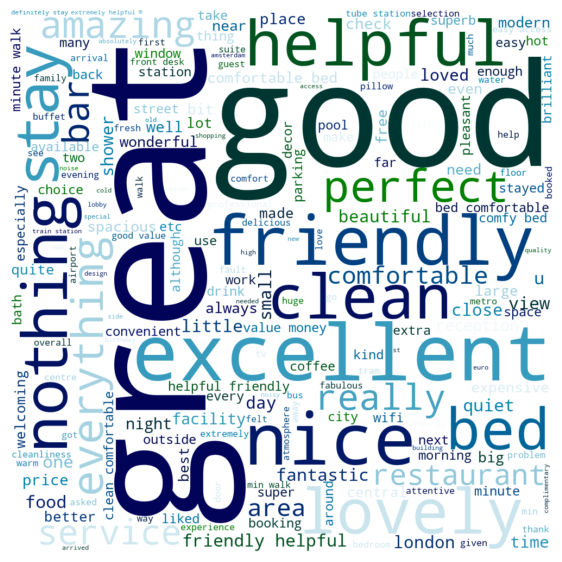

In [ ]:
# WordCloud for Positive Review

wordCloud_generator(train_pos, 'white', 'ocean')

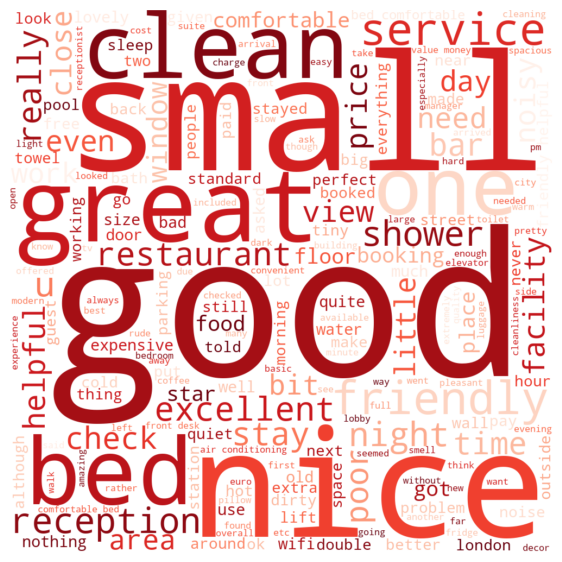

In [ ]:
# WordCloud for Negative Review

wordCloud_generator(train_neg, 'white', 'Reds')

The data is now ready to be split into training and testing data. We use 25% of the data for testing, while the remaining 75% will be used for training. 

In [ ]:
x = df[['Review']] 
y = df['posneg']

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)

We use a text vectorization technique called TF-IDF to transform the text data into a format that machine learning algorithms can understand. This technique gives a score to each word that reflects how important it is in relation to the entire dataset. It does this by reducing the influence of common, less meaningful words. This enables the models to focus on the most important words for the sentiment prediction. 

For the parameters: we set min_df to 10, meaning that it ignores words that appear in fewer than 10 rows (eliminates rare and uninformative terms). Max_df is set to 0.9, this ignores words that appear in more than 90% of the documents (often common or overly generic)

We use fit_tranform on the training data and only transform on the test data. This is because we don’t want to learn new vocabulary or IDF scores from the test data. This would cause data leakage. 


In [ ]:
# Initialize the TfidfVectorizer
tfidf = TfidfVectorizer(min_df=10, max_df=0.9, stop_words='english')

# Fit on training data only
tfidf_train = tfidf.fit_transform(X_train['Review'])

# Transform test data
tfidf_test = tfidf.transform(X_test['Review'])

print("Our x_train data ready to be used in the model")
print(X_train['Review'].head(10))
print("Our y_train data ready to be used in the model")
print(y_train.head(10))

X_train = tfidf_train
X_test = tfidf_test


Our x_train data ready to be used in the model
2847    location service quality value money unfortuna...
4336    huge comfy bed friendly staff good choice buff...
3386    hotel reasonable location near canary wharf ra...
1721    nice style design location bed small short tal...
2404            near espana plaza breakfast menu everyday
1818    excellent breakfast pleasant staff double room...
5418    great location stylish hotel really enjoyable ...
2676               price staff crowded restaurant amenity
4955    liked modern atmosphere spacious interior grou...
3612    location fantastic room choose big enough fami...
Name: Review, dtype: object
Our y_train data ready to be used in the model
2847    0
4336    0
3386    0
1721    0
2404    0
1818    0
5418    1
2676    0
4955    1
3612    0
Name: posneg, dtype: int64


In [ ]:
# Naive Bayes
nbmodel = MultinomialNB()
nbmodel.fit(X_train, y_train)
pred_nb = nbmodel.predict(X_test)

print("Naive Bayes")
print(classification_report(y_test, pred_nb))

Naive Bayes
              precision    recall  f1-score   support

           0       0.74      0.72      0.73       741
           1       0.73      0.75      0.74       759

    accuracy                           0.74      1500
   macro avg       0.74      0.74      0.74      1500
weighted avg       0.74      0.74      0.74      1500



In [ ]:
# Logistic Regression
lrmodel = LogisticRegression(random_state=42, max_iter=300)
lrmodel.fit(X_train, y_train)
pred_lr = lrmodel.predict(X_test)

print("Logistic Regression")
print(classification_report(y_test, pred_lr))

Logistic Regression
              precision    recall  f1-score   support

           0       0.73      0.75      0.74       741
           1       0.75      0.73      0.74       759

    accuracy                           0.74      1500
   macro avg       0.74      0.74      0.74      1500
weighted avg       0.74      0.74      0.74      1500



In [ ]:
# Linear SVC
svmmodel = LinearSVC(random_state=42)
svmmodel.fit(X_train, y_train)
pred_svm = svmmodel.predict(X_test)

print("Support Vector Machine (LinearSVC)")
print(classification_report(y_test, pred_svm))

Support Vector Machine (LinearSVC)
              precision    recall  f1-score   support

           0       0.72      0.71      0.71       741
           1       0.72      0.73      0.72       759

    accuracy                           0.72      1500
   macro avg       0.72      0.72      0.72      1500
weighted avg       0.72      0.72      0.72      1500



Here we build the LSTM model. We start off with embedding. Input_dim represents the size of the vocabulary. Output_dim represents the size of the embedding space for each word. Input_length specifies the length of input sequences. In other words the number of words in each sentence.

When we define the LSTM we also make it a bidirectional LSTM. This means that the model processes the input sequences in both directions. This increases the performance of the model significantly.

We use dropout to prevent overfitting. What the dropout does is randomly discarding some of the information that is passed through. 

In [ ]:
# Build the LSTM model

model = Sequential([
    Embedding(input_dim=10000, output_dim=128, input_length=maxlen),
    Bidirectional(LSTM(64)),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # For binary classification
])

c:\Users\Isakr\.virtualenvs\storefront-f6Kph3uA\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Here we compile the model starting with loss. The loss function measures how well the models's prediction the true labels. Here we use binary crossentropy, which is commonly used when you have two possible classes.

The optimizer controls how the model's weights are updates during training. Adam is often used for its efficiency. 

The metrics are used to evaluate the modelss performance. Here we use accuracy, which shows the proportion of correct predictions. Precision is the ratio of true positive predictions to all positive predictions in the model. Recall is the ratio of true positive to all actual positives. AUC (Area Under the Curve) shows the models ability to distinguish classes, in this case positive and negative. The higher the AUC, the better the model is at this. 

In [ ]:
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=[
        'accuracy',
        Precision(name='precision'),
        Recall(name='recall'),
        AUC(name='auc')
    ]
)

Here, we use the fit function to train the model. We specify 5 epochs, which means the model will pass through the entire dataset 5 times during training. The choice of 5 epochs helps balance the model’s learning process with the need for faster execution, allowing the program to complete quicker while still learning useful patterns from the data.

In [ ]:
history = model.fit(
    X_train_LSTM, y_train_LSTM,
    epochs=5, batch_size=64, validation_split=0.2
)

Epoch 1/5
57/57 ━━━━━━━━━━━━━━━━━━━━ 10s 74ms/step - accuracy: 0.5041 - auc: 0.5014 - loss: 0.6930 - precision: 0.5034 - recall: 0.5853 - val_accuracy: 0.7189 - val_auc: 0.7868 - val_loss: 0.6402 - val_precision: 0.7414 - val_recall: 0.6983
Epoch 2/5
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.7144 - auc: 0.7753 - loss: 0.5846 - precision: 0.7118 - recall: 0.7156 - val_accuracy: 0.7467 - val_auc: 0.8264 - val_loss: 0.5145 - val_precision: 0.7521 - val_recall: 0.7586
Epoch 3/5
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.8186 - auc: 0.8973 - loss: 0.4051 - precision: 0.8136 - recall: 0.8234 - val_accuracy: 0.7489 - val_auc: 0.8168 - val_loss: 0.6303 - val_precision: 0.7780 - val_recall: 0.7177
Epoch 4/5
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.8845 - auc: 0.9492 - loss: 0.2908 - precision: 0.8710 - recall: 0.9006 - val_accuracy: 0.7244 - val_auc: 0.7941 - val_loss: 0.6517 - val_precision: 0.7379 - val_recall: 0.7220
Epoch 5/5
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s

Here we evaluate the model's performance with our test set. It will print out the performance of the model with all the metrics previously mentioned. 

In [ ]:
loss, acc, prec, rec, auc = model.evaluate(X_test_LSTM, y_test_LSTM, verbose=1)
print(f"""Test metrics:
  Accuracy:  {acc:.4f}
  Precision: {prec:.4f}
  Recall:    {rec:.4f}
  AUC:       {auc:.4f}
""")

47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.7134 - auc: 0.7804 - loss: 0.8023 - precision: 0.6946 - recall: 0.7962
Test metrics:
  Accuracy:  0.7047
  Precision: 0.6759
  Recall:    0.7997
  AUC:       0.7727



Here we will generate two graphs to visually evaluate the performance of the model.

The first graph will monitor the models performance with accuracy and validation accuracy.

The second graph visualizes the how the loss changes over epochs. A decreasing loss inidicates that the model is learning well.

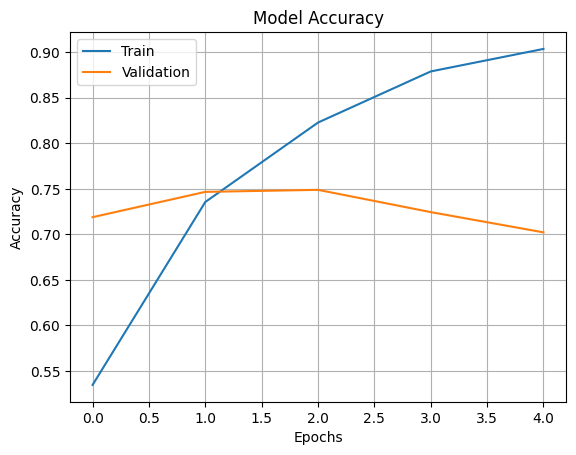

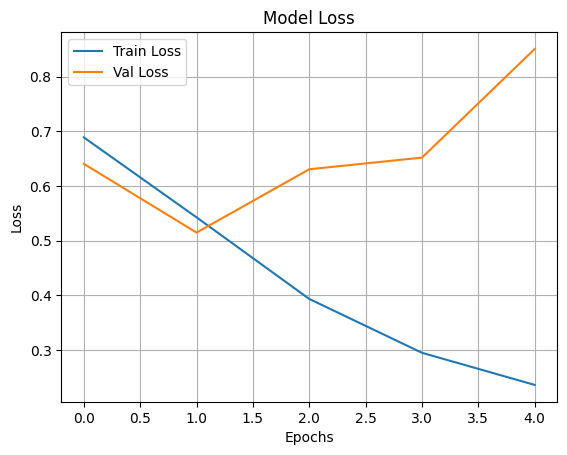

In [ ]:
# Accuracy plot
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# Loss plot
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()